# Separation prediction on general bodies

In this final notebook, we will combine the vortex panel method and the boundary layer solver to predict separation on any 2D shape and make drag predictions.

## BoundaryLayer module

As with `VortexPanel.py`, we've made a python file called `BoundaryLayer.py` which has the `march` function inside.

What will we need to interface these two modules?  `VortexPanel` doesn't need anything from `BoundaryLayer` - it just needs a geometry and angle of attack.

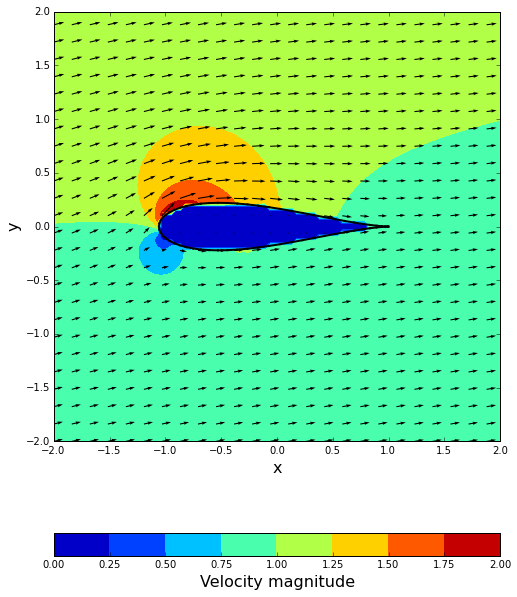

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from VortexPanel import Panel,solve_gamma_kutta,plot_flow,make_jukowski,make_circle

alpha = numpy.pi/16
N = 64
foil = make_jukowski(N)
solve_gamma_kutta(foil,alpha)
plot_flow(foil,alpha)

From the previous notebook we know the function `march` doesn't need the details of the geometry, but it does need:

- $s$: the distance along the boundary layer
- $u_e(x)$: the velocity on the edge of the boundary layer
- $u_e'(x)$: the tangential derivative of $u_e$
- $\nu$: the kinematic viscosity

The viscosity is obvious, but we'll need to get the other variables from the potential flow solution.

##### Quiz 1

What is the tangential velocity $u_e = \vec u\cdot\hat s$ on the fluid side of panel $p_i$?

1. $\left(\vec U +\sum_{j=0}^{N-1} \gamma_j \vec f_j(x_i,y_i)\right)\cdot \hat s_i$
1. $-\gamma_i$
1. $U_\infty$

Hint: Remember that we have set a boundary condition on the body side of the panel.

---
Next, let's get $s$. Note that a body will form **two** boundary layers, one on each side. We need to identify the starting point of these two flow regions.

##### Quiz 2

Where is the starting point of the two boundary layers?

1. The first and last panels: `foil[0]`, `foil[N-1]`
1. The panel where $u_e = 0$
1. The left-most panel, `foil[N/2]`

---

This makes it straightforward to split the body into the two boundary layer sections:

In [4]:
# split panels into two sections based on the flow velocity
def split_panels(panels):
    # positive velocity defines `top` BL
    top = [p for p in panels if p.gamma<=0]      
    # negative defines the `bottom`
    bottom = [p for p in panels if p.gamma>=0]
    # reverse array so panel[0] is stagnation
    bottom = bottom[::-1]

    return top,bottom

In [5]:
foil_top,foil_bottom = split_panels(foil)

Note that we changed the direction of the bottom array so that it runs from the stagnation point to the trailing edge, in accordance with the flow direction.

Lets plot them to make sure we got it right:

In [6]:
# plot panels with labels
def plot_segment(panels):
    pyplot.figure(figsize=(10,2))
    pyplot.axis([-1.2,1.2,-.3,.3])
    for i,p_i in enumerate(panels): 
        p_i.plot()
        if i%10 == 0:
            pyplot.scatter(p_i.xc,p_i.yc)
            pyplot.text(p_i.xc,p_i.yc+0.05, 
                'panel ['+'%i'%i+']',fontsize=12)

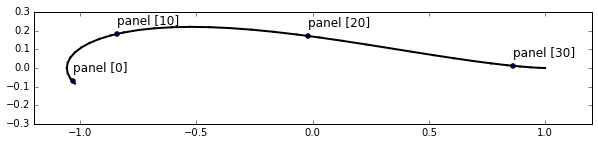

In [7]:
plot_segment(foil_top)

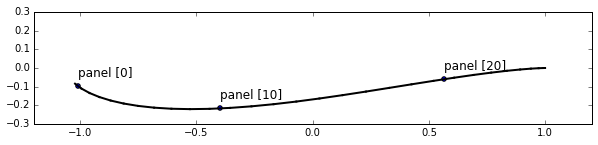

In [8]:
plot_segment(foil_bottom)

## Pohlhausen class

Now we just need to pull out the distance and velocity data from these `Panel` arrays and pass it to the `march` function. To keep this clean we define a new class `Pohlhausen`.

In [9]:
# Pohlhausen Boundary Layer class
class Pohlhausen:
    def __init__(self,panels,nu):
        self.u_e = [abs(p.gamma) for p in panels]   # tangential velocity
        self.s = numpy.empty_like(self.u_e)         # initialize distance array
        self.s[0] = panels[0].S
        for i in range(len(self.s)-1):              # fill distance array
            self.s[i+1] = self.s[i]+panels[i].S+panels[i+1].S           
        ds = numpy.gradient(self.s)     
        self.du_e = numpy.gradient(self.u_e,ds)     # compute velocity gradient

        self.nu = nu                                # kinematic viscosity
        self.xc = [p.xc for p in panels]            # x and ...
        self.yc = [p.yc for p in panels]            # y locations
        
    def march(self):
        # march down the boundary layer until separation
        from BoundaryLayer import march
        self.delta,self.lam,self.iSep = march(self.s,self.u_e,self.du_e,self.nu)

        # interpolate values at the separation point
        def sep_interp(y): return numpy.interp(    # interpolate function
            12,-self.lam[self.iSep:self.iSep+2],y[self.iSep:self.iSep+2])
        self.s_sep = sep_interp(self.s)
        self.u_e_sep = sep_interp(self.u_e)
        self.x_sep = sep_interp(self.xc)
        self.y_sep = sep_interp(self.yc)
        self.delta_sep = sep_interp(self.delta)

A few implementation notes:
 - The distance from the center of panel $i+1$ to panel $i$ is $\Delta s_{i+1} = S_i+S_{i+1}$, therefore $s_{i+1} = s_i+S_i+S_{i+1}$.
 - The `numpy.gradient` function is used to get $u_e'$. 
 - `Pohlhausen.march` calls `march` from the last notebook and then interpolates linearly to get values at the separation point.
 

## Circle boundary layer

Let's test this with the case we tried before, the flow around a circle. But this time we'll use the external flow from the vortex panel method instead of the analytic solution.

##### Quiz 3

Why do I keep testing code on cases we've seen before?

1. I'm terribly forgetful
1. New examples take work
1. I want to validate new code by comparing to known answers

---
##### Numerical fundamental: Validation
##### Every piece of code must be tested against a nontrivial example with a known solution

First lets check that $s$, $u_e$, and $u_e'$ are computed correctly:

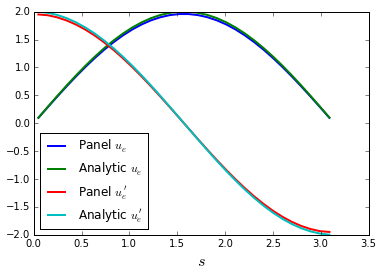

In [10]:
circle = make_circle(N)             # set-up circle
solve_gamma_kutta(circle)           # solve flow
top,bottom = split_panels(circle)   # split panels
nu = 1e-5                           # set viscosity
top = Pohlhausen(top,nu)            # get BL inputs
u_e = 2.*numpy.sin(top.s)           # analytic u_e
du_e = 2.*numpy.cos(top.s)          # analytic du_e

# compare the boundary layer inputs
pyplot.xlabel(r"$s$",fontsize=16)
pyplot.plot(top.s,top.u_e, lw=2, label=r'Panel $u_e$')
pyplot.plot(top.s,u_e, lw=2, label=r'Analytic $u_e$')
pyplot.plot(top.s,top.du_e, lw=2, label=r"Panel $u_e'$")
pyplot.plot(top.s,du_e, lw=2, label=r"Analytic $u_e'$")
pyplot.legend(loc='lower left')

Those look very good. Now lets `march` and look at $\delta$ and the separation point. 

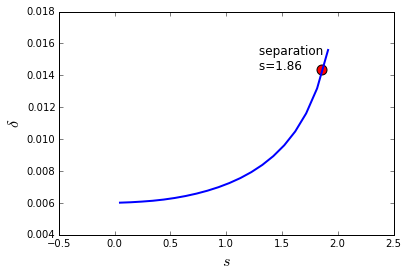

In [11]:
top.march()         # solve the boundary layer flow
i = top.iSep+2      # last point to plot

# plot the boundary layer thicknes and separation point
pyplot.ylabel(r'$\delta$', fontsize=16)
pyplot.xlabel(r'$s$', fontsize=16)
pyplot.plot(top.s[:i],top.delta[:i],lw=2)
pyplot.scatter(top.s_sep,top.delta_sep, s=100, c='r')
pyplot.text(top.s_sep-0.6,top.delta_sep, 
    ' separation \n s='+'%.2f' % top.s_sep,fontsize=12)

Same answer as the previous notebook. Good.

Now that we know the code is working, lets write a function to set-up, solve, and plot the separation points for the boundary layer flow.

In [12]:
def solve_plot_boundary_layers(panels,alpha=0,nu=1e-5):

    # split the panels
    top_panels,bottom_panels = split_panels(panels)
    
    # Set up and solve the top boundary layer
    top = Pohlhausen(top_panels,nu)
    top.march()

    # Set up and solve the bottom boundary layer
    bottom = Pohlhausen(bottom_panels,nu)
    bottom.march()
    
    # plot flow with separation points
    plot_flow(panels,alpha)
    pyplot.scatter(top.x_sep, top.y_sep, s=100, c='r')
    pyplot.scatter(bottom.x_sep, bottom.y_sep, s=100, c='g')
    
    return top,bottom

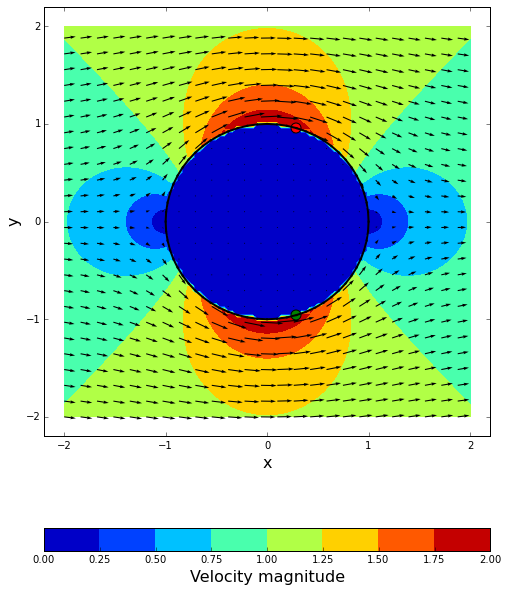

In [13]:
top,bottom = solve_plot_boundary_layers(circle)

The red and green dots mark the separation point for the top and bottom boundary layer, respectively.

Separation occurs soon after the flow begins to decelerate. Physically, the boundary layer loses energy to friction as it travels over the front of the body (remember how large $C_F$ was?) and can not cope with the adverse pressure gradient on the back of the body.

## Jukowski foil validation

Now lets write a function to get the complete flow around a Jukowski foil:

In [14]:
def predict_jukowski_separation(t_c,alpha=0,N=128):
    # set dx to gets the correct t/c
    foil = make_jukowski(N,dx=t_c-0.019)

    # find and print t/c
    x0 = foil[N/2].xc
    c = foil[0].xc-x0
    t = 2.*numpy.max([p.yc for p in foil])
    print "t/c = "+"%.3f"%(t/c)

    # solve potential flow and boundary layer evolution
    solve_gamma_kutta(foil,alpha)
    top,bottom = solve_plot_boundary_layers(foil,alpha)

    # print message
    print ("Separation at x/c = "+"%.3f"%
           ((top.x_sep-x0)/c)+" from the leading edge")

t/c = 0.198
Separation at x/c = 0.136 from the leading edge


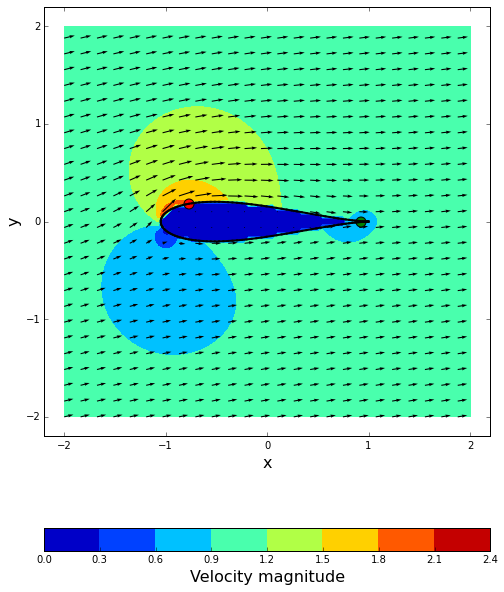

In [15]:
predict_jukowski_separation(0.2,alpha)

##### Quiz 4

We know $\nu$ doesn't impact separation. How *can* you move the separation points?

1. Change the foil thickness
1. Change the angle of attack
1. Change the resolution

---

We can make sure the behavoir above is correct by validating against the analytic solution for simple geometries. Here is a summary figure from Chapter 3 of Hoerner's *Fluid-Dynamic Drag*

---
![Hoerner Drag, Fig 5, Chap 3](resources/separation_hoerner.png)

---
There are two Jukowski examples: $t/c=0.15$ which separates at $x/c\approx0.49$ from the leading edge, and  $t/c=0.17$, which separates at $x/c\approx0.39$.

t/c = 0.150
Separation at x/c = 0.494 from the leading edge


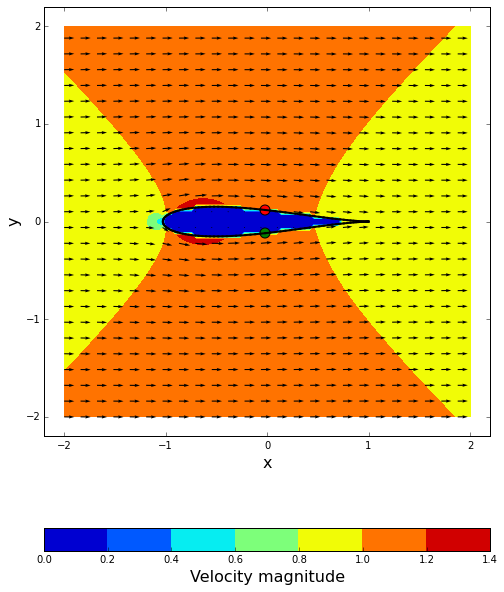

In [16]:
predict_jukowski_separation(t_c=0.15)

The $t/c=0.15$ case matches very well with Hoerner's picture. 

t/c = 0.170
Separation at x/c = 0.459 from the leading edge


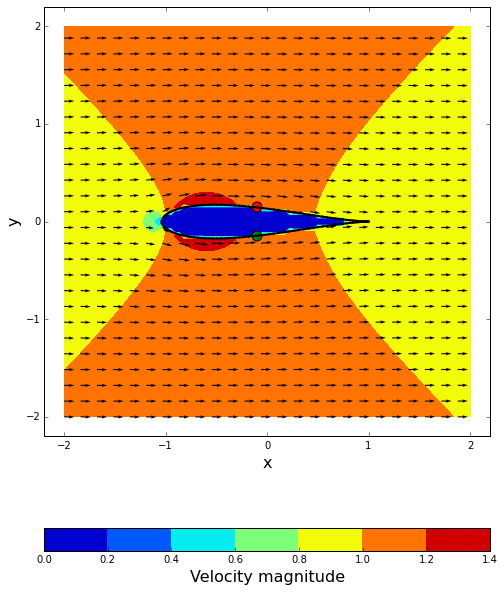

In [17]:
predict_jukowski_separation(t_c=0.17)

##### Quiz 5

What could be the cause of the ~$15\%$ discrepancy in the $t/c=0.17$ case?

1. Error in Hoerner
1. Error in Pohlhausen boundary layer ODE
1. Error in numerical method (`VortexPanel`, `BoundaryLayer`, etc)

## Ellipse validation

Let's see how we fair in the ellipse cases. From the Hoerner image I estimate:

$t/c$| 1/2 | 1/4 | 1/8 
---|---|---|---|---
$x/c$| $0.75$ | $0.85$ | $0.92$ 

In [18]:
def predict_ellipse_separation(t_c,N=128,alpha=0):
    ellipse = make_circle(N,t_c)
    print "t/c = "+"%.3f"%(t_c)

    # solve potential flow and boundary layer evolution
    solve_gamma_kutta(ellipse,alpha)
    top,bottom = solve_plot_boundary_layers(ellipse,alpha)

    # print message
    print ("Separation at x/c = "+"%.3f"%
           ((top.x_sep+1)/2.)+" from the leading edge")    

t/c = 0.500
Separation at x/c = 0.758 from the leading edge


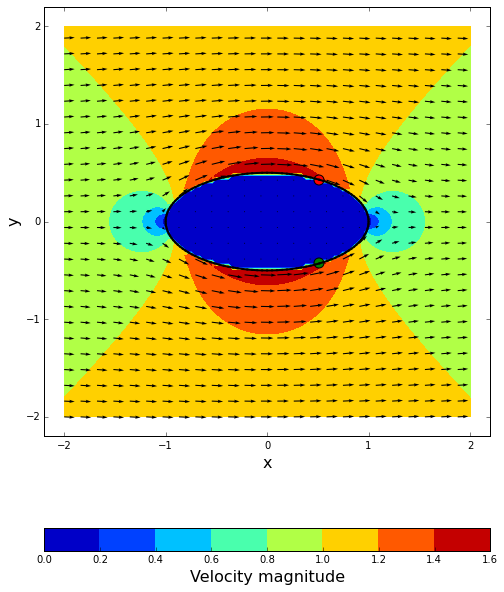

In [19]:
predict_ellipse_separation(t_c=0.5)

t/c = 0.250
Separation at x/c = 0.858 from the leading edge


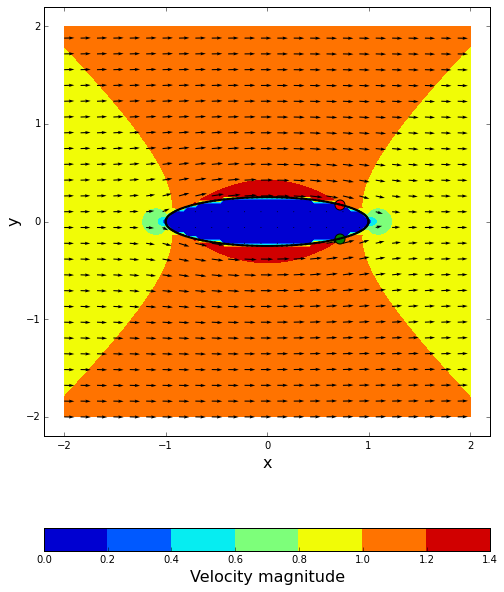

In [20]:
predict_ellipse_separation(t_c=0.25)

t/c = 0.125
Separation at x/c = 0.923 from the leading edge


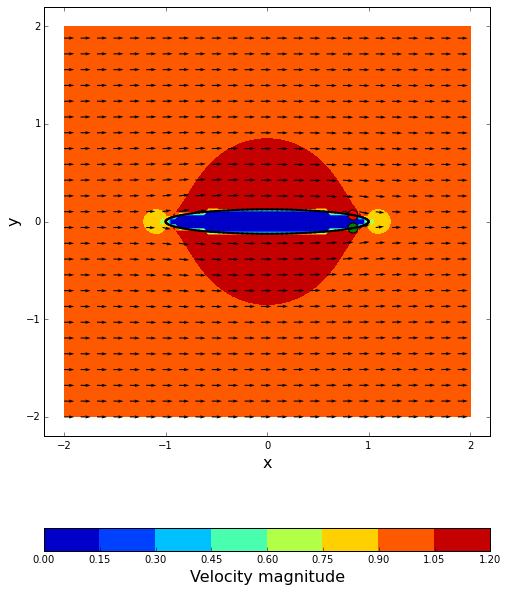

In [21]:
predict_ellipse_separation(t_c=0.125)

So I get the feeling Hoerner has a typo... that's the first one I've found.

## Pressure force estimates

Now that we can predict the separation point, we can make non-zero pressure force estimates.

The pressure force on the body is

$$\vec F_p = \oint_{\cal S} p \hat n ds$$

where $\cal S$ is the body surface and $\hat n$ is the normal to the surface. 

##### Quiz 6

What is the equation for the pressure coefficient $c_p(s)$?

1. $c_p(s) = 1-4\sin(s)$
1. $c_p(s) = 1-u_e^2(s)/U_\infty^2$
1. $c_p(s) = (p(s)-p_\infty)/(\frac 12\rho U_\infty^2)$

---
Therefore, the drag coefficient is

$$C_D = \frac{-F_x}{\frac 12 \rho U^2_\infty A} = \frac1w\oint_{\cal S} c_p s_y ds$$

where $A$ is the 2D projected area of the body (the width) and $s_y = -n_x$.

Using the vortex panel method we can determine the potential flow solution for $c_p$, but what does $c_p$ look like in a real flow with separation? 

---
![Pressure coefficient](resources/graphics5.png)

---
I've sketched the results for the flow around a circular cylinder above. The measured pressure at the front of a body in a viscous fluid is fairly well predicted by potential flow. 

However, the pressure coefficient completely deviates from the potential flow prediction near the point of separation. **Indeed it remains essentially constant in the separated flow region.** 

##### Quiz 7

What would be a simple way to estimate the drag on a body?

1. Integrate $c_p$ from the vortex panel method.
1. Set $c_p(s) = c_p(s_{sep})$ for $s>s_{sep}$, and then integrate.

---

##### Your turn

Compute $C_D$ for the circle and compare to the laminar experimental value of ~$1$.

In [22]:
# you code here

---
Ignore the line below - it just loads the style sheet.

In [23]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()